# Deep Convolutional Generative Adversarial Network - Anime Faces

A experiment of the simplies form of GAN model for generating anime faces to see its limiations and capabilities.

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.3 keras matplotlib graphviz moviepy

## Import all Modules

In [2]:
from IPython import display
import time
from IPython.display import Image
import os
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import imageio
import math
import glob
import PIL
import PIL.Image
import tensorflow as tf
from keras import layers, backend
import keras

# initialize tf.distribute.MirroredStrategy
strategy = tf.distribute.MirroredStrategy(devices=None)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

/media/programming/projects/machineLearning/ML/venv/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


2023-04-01 07:16:22.240645: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 07:16:22.262817: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 07:16:22.262975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-01 07:16:22.263539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
tf.__version__

'2.9.3'

### Configure Output Directory
Set the output directory where all the results will be storaged.

In [4]:
root_dir = "result/anime_gan"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [5]:
def load_from_directory(data_dir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
        
    # Search and find number of elements within directory, recursively.
    image_count = len(list(data_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_dir, image_count))

    #
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1. / 255.0)

    # Translate [0,255] -> [-1, 1]
    normalized_ds = configure_for_performance(train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0),
                                              AUTOTUNE)

    return normalized_ds


In [6]:
latent_space_size = 128
BATCH_SIZE = 48
IMAGE_SIZE = (128, 128)
EPOCHS = 56

data_directory_path = "data-gan/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

# Setup to support multiple GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_images = train_images.with_options(options)


data-gan: Found 92108 files
Found 92108 files belonging to 1 classes.
Number of batches 1919 of 48 elements


## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size.

In [7]:
def make_generator_model(input_shape):
    model = tf.keras.Sequential()

    init = tf.keras.initializers.TruncatedNormal(stddev=0.02)

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - 4, 0)

    # Foundation for 4x4 image
    n_nodes = 1024 * 4 * 4
    model.add(layers.Dense(
        n_nodes, kernel_initializer=init, input_dim=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Reshape((4, 4, 1024)))
    # Note: None is the batch size
    assert model.output_shape == (None, 4, 4, 1024)

    # upsample to 8x8
    model.add(layers.Conv2DTranspose(filters=1024, kernel_size=(4, 4), strides=(2, 2),
                                     use_bias=False, padding='same', kernel_initializer=init))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Number of based on the result resolution.
    for i in range(0, num_layers + 1):
        filter_size = int(512 / (2 ** i))
        image_size = (16 * (2 ** i), 16 * (2 ** i))

        model.add(layers.Conv2DTranspose(filters=filter_size, kernel_size=(4, 4), strides=(2, 2), use_bias=False, padding='same',
                                         kernel_initializer=init))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())
        assert model.output_shape == (
            None, image_size[0], image_size[1], filter_size)

    # output layer
    model.add(layers.Conv2DTranspose(filters=3, kernel_size=(4, 4), strides=(
        1, 1), padding='same', kernel_initializer=init))
    model.add(layers.Activation('tanh'))

    assert model.output_shape == (None, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)

    return model

Use the (as yet untrained) generator to create an image.

2023-04-01 07:16:33.642576: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-01 07:16:33.746012: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-04-01 07:16:34.766200: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


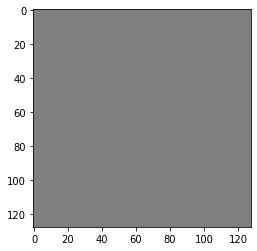

In [8]:

latent_space_c = (latent_space_size)
generator = make_generator_model(latent_space_c)

noise = tf.random.normal([1, latent_space_size])

generated_image = generator(noise, training=False)

# Convert image from [-1,1] to [0,1]
rgb = (generated_image[0, :, :, 0:3] + 1.0) / 2.0

plt.imshow(asarray(rgb))


### The Discriminator

The discriminator is a CNN-based image classifier.

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    n_layers = max(int(math.log2(IMAGE_SIZE[1])) - 3, 0)

    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), use_bias=False, padding='same',
                            input_shape=[IMAGE_SIZE[0], IMAGE_SIZE[1], 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    for i in range(0, n_layers):
        filter_size = 128 * (2 ** i)
        kernel_size = (5, 5)
        model.add(layers.Conv2D(filter_size, kernel_size=kernel_size,
                                strides=(2, 2), use_bias=False, padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1, kernel_size=4, strides=(
        2, 2), padding='valid', use_bias=False))
    model.add(layers.Flatten())
    model.add(layers.Activation('sigmoid'))

    return model

Example of using the discriminator for determine if a image is real. However, since either model are trained, the result will not be useful.

In [10]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.49999094]], shape=(1, 1), dtype=float32)


## Generator Model

In [11]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             2113536   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 1024)       16777216  
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 1024)       4

## Discriminator Model

In [12]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1728      
                                                                 
 batch_normalization_6 (Batc  (None, 64, 64, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       204800    
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)      

In [13]:
def generate_grid_image(model, latent_space, figsize=(8, 8), subplotsize=(3, 3)):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(latent_space, training=False)

    fig = plt.figure(figsize=figsize)
    for i in range(predictions.shape[0]):
        plt.subplot(subplotsize[0], subplotsize[1], i + 1)
        rgb = (predictions[i, :, :, 0:3] + 1.0) / 2.0
        plt.imshow(asarray(rgb))
        plt.axis('off')
    plt.close()
    return fig


def generate_and_save_images(model, epoch, latent_space):
    fig = generate_grid_image(model=model, latent_space=latent_space)
    fig.savefig(os.path.join(root_dir, 'image_at_epoch_{:04d}.png'.format(epoch)), transparent=False)
    plt.show()


In [14]:
# Generate a big image.
def generateBigBridImage(model, grid_size, latent_space=None):
    width, height = grid_size

    if latent_space == None:
        latent_space = tf.random.normal([width * height, latent_space_size])

    generated_images = model(latent_space, training=False)

    fig = plt.figure(figsize=(width * 2, height * 2))
    for i in range(generated_images.shape[0]):
        plt.subplot(height, width, i+1,)

        plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
        plt.axis("off")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.close()
    return fig


## Show the neuron network layers
When initialize the generator model, the output is a completely just noise.

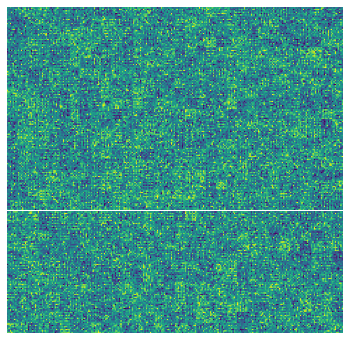

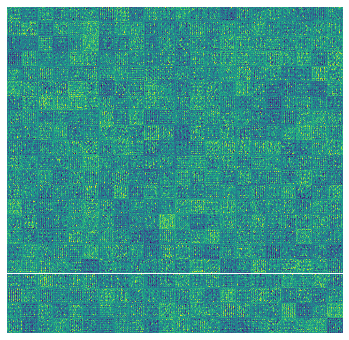

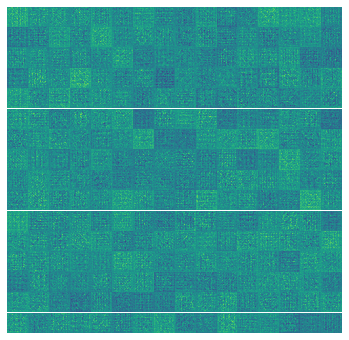

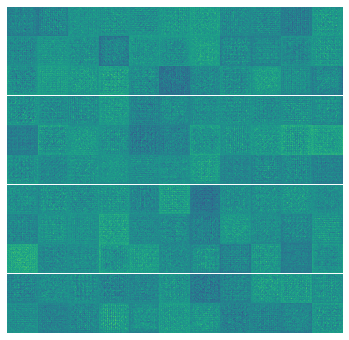

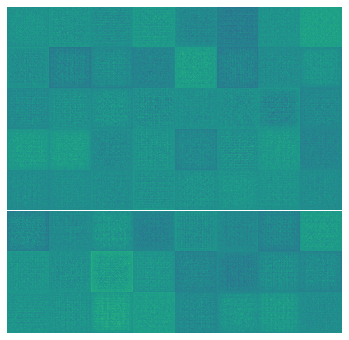

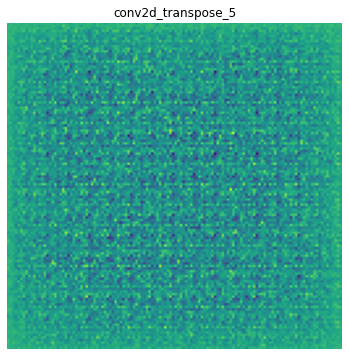

In [15]:
def get_layer_outputs(model, layer_name, input_data):
    layer_output=model.get_layer(layer_name).output

    intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output)

    intermediate_prediction=intermediate_model(input_data, training=False)
    return intermediate_prediction

def generate_each_layer(model, latent_space, grid_size):
    inp = model.input                                           # input placeholder
    
    # Testing
    test = np.random.random(latent_space.shape)[np.newaxis, ...]
    for layer in generator.layers:
        
        if 'conv2d' in layer.name:
            layer_outs = get_layer_outputs(generator, layer.name, latent_space)

            #
            width, height = grid_size
            nr_filters = layer_outs.shape[3]
            nr_images = layer_outs.shape[0]
            square = int(math.sqrt(nr_filters))

            #
            fig = plt.figure(figsize=(width * 2, height * 2))
            plt.title(layer.name)

            for i in range(nr_images):
                for k in range(0, nr_filters):
                    if k < square * square:

                        plt.subplot(square, square, k+1)

                        plt.imshow(((layer_outs[i, :, :, k] + 1.0) / 2.0), aspect='auto')
                        plt.axis("off")
            plt.subplots_adjust(wspace=0.005, hspace=0.005)
            plt.show()

grid_size = (3, 3)
noise__ = tf.random.normal([1, latent_space_size])
generate_each_layer(generator, noise__, grid_size)


In [16]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show(block=False)


2023-04-01 07:17:20.765277: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


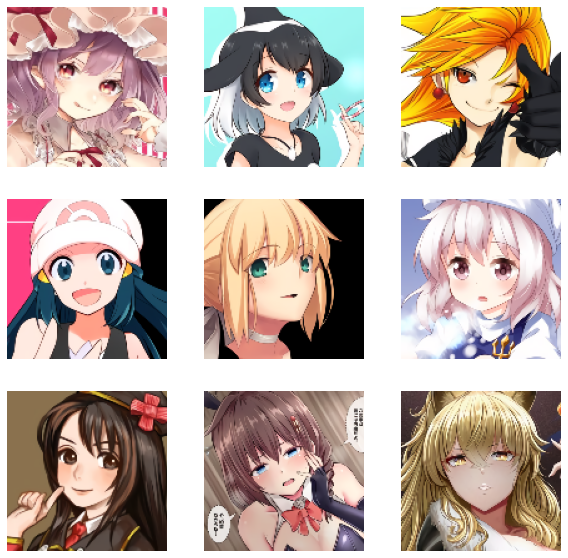

In [17]:
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF.
seed = tf.random.normal([num_examples_to_generate, latent_space_size])

plt.figure(figsize=(10, 10))
for images in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow((images[i].numpy() + 1.0) / 2.0)
        plt.axis("off")
plt.show()

In [18]:

class DCGAN(keras.Model):

    def __init__(self, generator_model, discriminator_model, **kwargs):

        super(DCGAN, self).__init__(**kwargs)
        self.generator = generator_model
        self.discriminator = discriminator_model
        self.latent_space_size = generator_model.input_shape[1] # Lazy approuch


        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(
            from_logits=False)

    def generator_loss(self, fake_output):

        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    def discriminator_loss(self, real_output, fake_output, smooth=0.11):

        # label for real image is (1-smooth)
        real_loss = self.cross_entropy(tf.ones_like(
            real_output)*(1-smooth), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss

        return total_loss

    def compile(self, generator_optimizer, discriminator_optimizer):
        super(DCGAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

    @tf.function
    def train_step(self, data):

        batch_size = tf.shape(data)[0]

        # feed a random input to generator
        seed = tf.random.normal(shape=(batch_size, self.latent_space_size))

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            # generate image using generator
            generated_image = self.generator(seed, training=True)

            # discriminator's prediction for real image
            real_output = self.discriminator(data, training=True)

            # discriminator's estimate for fake image
            fake_output = self.discriminator(
                generated_image, training=True)

            # compute loss
            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

            # optimize generator first
            generator_grad = gen_tape.gradient(
                gen_loss, self.generator.trainable_variables)
            discriminator_grad = disc_tape.gradient(
                disc_loss, self.discriminator.trainable_variables)

            # optimize discriminator after generator
            self.generator_optimizer.apply_gradients(
                zip(generator_grad, self.generator.trainable_variables))
            self.discriminator_optimizer.apply_gradients(
                zip(discriminator_grad, self.discriminator.trainable_variables))

        return {
            "generator loss": gen_loss,
            "discriminator_loss": disc_loss
        }


In [19]:
class checkpoint_callback(tf.keras.callbacks.Callback):

    def __init__(self, generator_path, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.generator_path = generator_path

    def on_epoch_end(self, epoch, logs=None):
        if not os.path.exists(os.path.join(root_dir, "Weights")):
            os.mkdir(os.path.join(root_dir, "Weights"))
        self.model.generator.save_weights(os.path.join(root_dir, "Weights/generator_weights.h5"))
        self.model.discriminator.save_weights(os.path.join(root_dir,
                                                           "Weights/discriminator_weights.h5"))
        self.model.generator.save(self.generator_path)


class save_images(tf.keras.callbacks.Callback):

    def __init__(self, noise, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.noise = noise

    def on_epoch_end(self, epoch, logs=None):
        generate_and_save_images(self.model.generator, epoch, self.noise)
        grid_size = (16, 9)
        big_fig = generateBigBridImage(generator, grid_size)
        big_fig.savefig(os.path.join(root_dir, 'big_image_at_epoch_{:04d}.png'.format(
            epoch + 1)), transparent=None)


In [20]:
generator_model_filepath = os.path.join(root_dir, "dcgan-anime-generator.h5")

learning_rate = 0.00015
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=False)

generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule, beta_1=0.5)

fixed_latent_space_noise = tf.random.normal(
    [num_examples_to_generate, latent_space_size])
dcgan = DCGAN(generator, discriminator)
dcgan.compile(generator_optimizer, discriminator_optimizer)
history = dcgan.fit(train_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    callbacks=[
                        save_images(noise=fixed_latent_space_noise),
                        checkpoint_callback(generator_path=generator_model_filepath)
                    ]
                    )

Epoch 1/56


2023-04-01 07:17:25.862106: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-01 07:17:25.862138: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1918/1919 [============================>.] - ETA: 0s - generator loss: 2.8644 - discriminator_loss: 1.0665

2023-04-01 07:22:26.271815: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-01 07:22:26.271853: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.41GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1919/1919 [==============================] - 312s 161ms/step - generator loss: 2.8636 - discriminator_loss: 1.0662
Epoch 2/56
1919/1919 [==============================] - 307s 160ms/step - generator loss: 2.3552 - discriminator_loss: 0.9001
Epoch 3/56
1919/1919 [==============================] - 308s 161ms/step - generator loss: 2.5238 - discriminator_loss: 0.8417
Epoch 4/56
1919/1919 [==============================] - 316s 165ms/step - generator loss: 2.7129 - discriminator_loss: 0.7711
Epoch 5/56
1919/1919 [==============================] - 306s 159ms/step - generator loss: 2.8530 - discriminator_loss: 0.7283
Epoch 6/56
1919/1919 [==============================] - 307s 160ms/step - generator loss: 2.8332 - discriminator_loss: 0.7253
Epoch 7/56
1919/1919 [==============================] - 306s 160ms/step - generator loss: 2.8095 - discriminator_loss: 0.7112
Epoch 8/56
1919/1919 [==============================] - 304s 158ms/step - generator loss: 2.8438 - discriminator_loss: 0.6973
Epo

# History Result

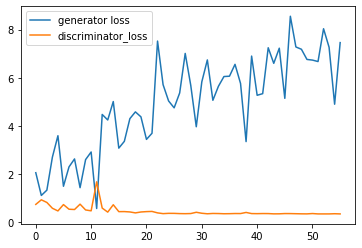

In [21]:
plotCostHistory(history.history)

# Final Generator Image Result

In [22]:
# Display a single image using the epoch number
big_fig = generateBigBridImage(generator, (16, 9))
plt.show()


## Save Final Models

In [23]:
generator_model_filepath = os.path.join(root_dir, "dcgan-anime-generator.h5")
generator.save(generator_model_filepath)
discriminator.save(os.path.join(root_dir, "dcgan-anime-discriminator.h5"))

## Load Model and Generator Results

In [24]:
generator_model_filepath = os.path.join(root_dir, "dcgan-anime-generator.h5")
generator = tf.keras.models.load_model(generator_model_filepath)

In [25]:
grid_size = (14, 6)
generateBigBridImage(generator, grid_size)
plt.show()

## Show each layer of the generator model
This allows to a get an idea of what how the neuron see and how each layer becomes more and more detailed.

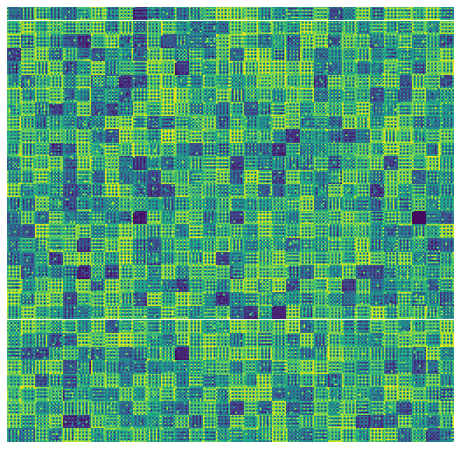

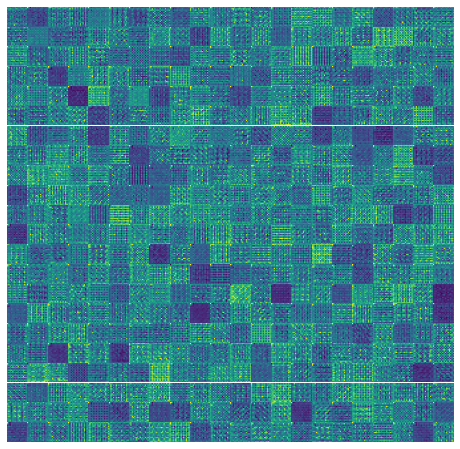

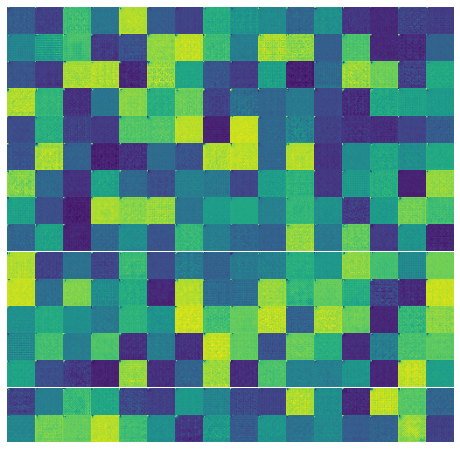

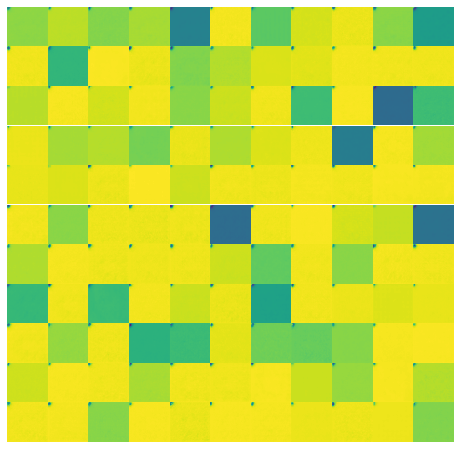

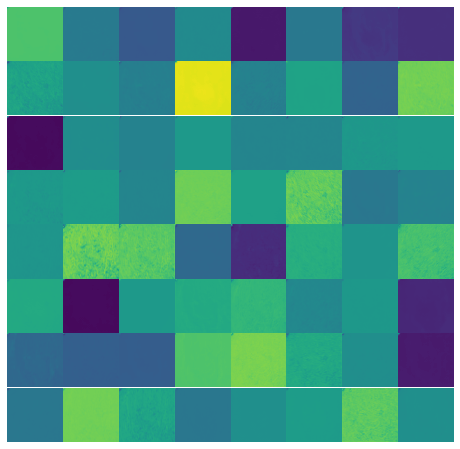

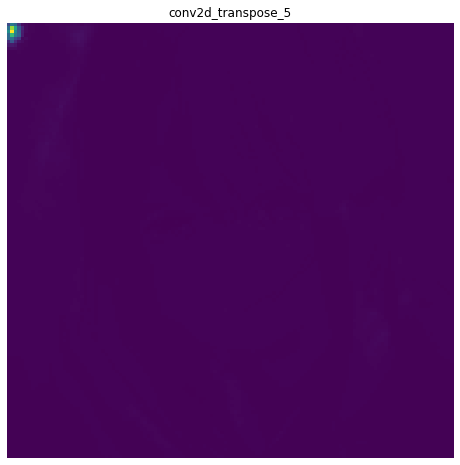

In [26]:
grid_size = (4, 4)
noise__ = tf.random.normal([16, latent_space_size])
generate_each_layer(generator, noise__, grid_size)

## Create a GIF


Use `imageio` to create an animated gif using the images saved during training.

In [27]:
anim_file = os.path.join(root_dir, 'anime-dcgan.gif')

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(os.path.join(root_dir, 'image*.png'))
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)


Image(url=anim_file)

/tmp/ipykernel_802615/871862930.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipykernel_802615/871862930.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Generate Transition Image

By adjusting between two points within the latent space and interpolated of number of frames.

In [28]:
def interpolate(zs, steps):
    out = []
    for i in range(len(zs)-1):
        for index in range(steps):
            fraction = index/float(steps)
            out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
    return out


In [29]:
def generate_transition(model, gris_size):
      nr_elemenets = 4
      seeds = np.random.randint(10000, size=2)
      zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
            for s in seeds]
      
      all_latents = interpolate(zs, nr_elemenets)

      generated_images = model(latent_space, training=False)

      width, height = grid_size
      fig = plt.figure(figsize=(width * 2, height * 2))
      for i in range(generated_images.shape[0]):
            plt.subplot(height, width, i+1,)

            plt.imshow(((generated_images[i, :, :, :] + 1.0) / 2.0), aspect='auto')
            plt.axis("off")
      plt.subplots_adjust(wspace=0, hspace=0)
      plt.close()



In [30]:
import scipy
import moviepy.editor


In [31]:

fps = 15
duration_sec = 5
smoothing_sec = 1.0
num_frames = 4 * fps

shape = [num_frames, np.prod(latent_space_size)]

nr_elemenets = 9

seeds = np.random.randint(10000, size=2)
zs = [tf.random.normal([nr_elemenets, latent_space_size], seed=s)
      for s in seeds]

all_latents = interpolate(zs, num_frames)


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]

    #
    fig = generate_grid_image(generator, latents, (5, 5), (3, 3))

    #
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return data


gif_filepath = os.path.join(root_dir, ('transition_grid_{0}.gif'.format(seeds[0])))
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_gif(gif_filepath, fps=fps)


MoviePy - Building file result/anime_gan/transition_grid_4122.gif with imageio.


In [32]:
Image(url=gif_filepath)
